# Analyze Energy Ratios with Wake Steering

In this notebook, we will compare energy ratios computed using data from baseline and wake steering control periods. The energy ratios for the two control cases will be compared to evaluate the impact of wake steering on the energy production of the test turbines.

In [1]:
import copy
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from flasc import FlascDataFrame
from flasc.analysis import energy_ratio as er, total_uplift_power_ratio as tup
from flasc.analysis.analysis_input import AnalysisInput
from flasc.utilities.utilities_examples import load_floris_smarteole as load_floris
from flasc.visualization import plot_binned_mean_and_ci

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Step 0: Load processed data

Load the processed SCADA data with power curve filtering and northing calibration applied and inspect

In [3]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada = load_data()

In [4]:
df_scada.describe()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,wd_004,wd_005,wd_006,wind_vane_005,target_yaw_offset_005,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
count,134661,107963.000000,104981.000000,91702.000000,100774.000000,105342.000000,99677.000000,106162.000000,107963.000000,104981.000000,...,105342.000000,99677.000000,106162.000000,99677.000000,99677.000000,131704.000000,131699.000000,130266.000000,1.346610e+05,115725.000000
mean,2020-04-04 18:49:02.648873472,777.708801,722.314758,788.448608,650.102051,714.341980,707.234131,735.000000,7.992578,7.441975,...,147.802322,152.649887,145.970200,0.825125,0.786913,147.975884,7.286751,639.086548,1.100000e-01,147.127971
min,2020-02-17 16:30:00,0.001000,0.003000,0.002000,0.009000,0.007000,0.032000,0.000000,1.483000,2.746000,...,0.022003,0.009750,0.191750,-43.056999,-0.000000,0.005936,0.101000,-45.498859,1.100000e-01,0.035299
25%,2020-03-12 01:51:00,235.326004,214.001999,246.753754,192.749237,205.838989,173.522003,219.312500,6.128000,5.577000,...,50.160999,52.731747,49.358002,-5.912000,0.000000,47.813656,5.121595,98.970131,1.100000e-01,47.609299
50%,2020-04-04 10:58:00,571.359985,528.625000,593.072998,467.079498,504.357483,504.005005,540.981506,7.448000,7.027000,...,126.497002,163.868759,134.247757,0.187000,0.000000,138.522042,7.423318,422.463989,1.100000e-01,136.630460
75%,2020-04-27 20:03:00,1238.735962,1119.993042,1244.010986,997.394531,1098.766724,1124.659058,1134.179199,9.587500,8.942000,...,235.623001,235.056763,232.824249,6.927000,0.000000,235.295441,9.361652,1049.996338,1.100000e-01,233.829382
max,2020-05-24 23:59:00,2064.696045,2065.387939,2051.489990,2062.987061,2064.689941,2078.750977,2076.895996,20.851999,21.240999,...,359.997009,359.980743,359.988770,59.181999,20.000000,359.991814,20.422459,2147.802246,1.100000e-01,359.957790
std,NaN,639.332153,609.761963,636.423706,560.708984,617.146301,622.352234,618.290527,2.548205,2.501244,...,99.606598,97.270058,97.408218,10.048730,3.216291,101.749594,3.104111,629.421387,8.326704e-17,100.096957


In [5]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

# Step 1: Evaluate offsets

Compare the targeted offsets against what was achieved (as measured by the vane on the steering turbine SMV6 (index=5))

In [6]:
# Parameters
start_of_offset = 200  # deg
end_of_offset = 240  # deg

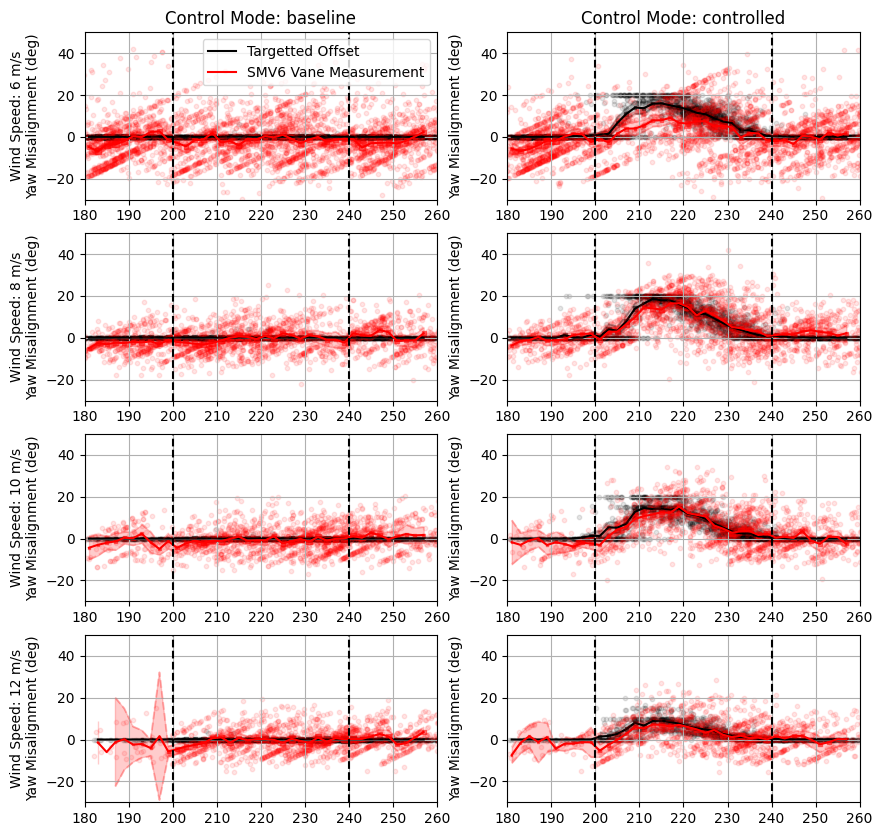

In [7]:
# Add a rounded ws column
df_scada = df_scada.assign(ws_round=df_scada.ws_005.round(), wd_to_plot=df_scada.wd_005)

# Limit to a few wind speeds for plotting
wind_speeds_to_plot = [6, 8, 10, 12]
df_plot = df_scada[df_scada.ws_round.isin(wind_speeds_to_plot)]

# Melt together targeted and achieved
df_plot = (
    df_plot[["wd_to_plot", "ws_round", "target_yaw_offset_005", "wind_vane_005", "control_mode"]]
    # .melt(id_vars=['wd_round','ws_round','control_mode'],
    #       var_name='offset_type',
    #       value_name='offset_value')
    .sort_values(["wd_to_plot", "ws_round"])
)

# Set up binning plots
x_edges = np.arange(start_of_offset - 20, end_of_offset + 20, 2)

fig, axarr = plt.subplots(len(wind_speeds_to_plot), 2, figsize=(10, 10))

for ws_idx, ws in enumerate(wind_speeds_to_plot):
    for c_idx, control_mode in enumerate(["baseline", "controlled"]):
        ax = axarr[ws_idx, c_idx]
        df_sub = df_plot[(df_plot.ws_round == ws) & (df_plot.control_mode == control_mode)]

        plot_binned_mean_and_ci(
            df_sub.wd_to_plot,
            df_sub.target_yaw_offset_005,
            color="k",
            x_edges=x_edges,
            label="Targetted Offset",
            ax=ax,
        )

        plot_binned_mean_and_ci(
            df_sub.wd_to_plot,
            df_sub.wind_vane_005,
            color="r",
            x_edges=x_edges,
            label="SMV6 Vane Measurement",
            ax=ax,
        )

        ax.set_xlim([start_of_offset - 20, end_of_offset + 20])
        ax.set_ylim([-30, 50])
        ax.grid(True)
        ax.axvline(start_of_offset, color="k", ls="--")
        ax.axvline(end_of_offset, color="k", ls="--")

        if ws_idx == 0:
            ax.set_title(f"Control Mode: {control_mode}")

        if c_idx == 0:
            ax.set_ylabel(f"Wind Speed: {ws} m/s\nYaw Misalignment (deg)")
        else:
            ax.set_ylabel("Yaw Misalignment (deg)")

        if (ws_idx == 0) and (c_idx == 0):
            ax.legend()

In [8]:
# Limit the data to this region
df_scada = df_scada[
    (df_scada.wd_smarteole > (start_of_offset - 20))
    & (df_scada.wd_smarteole < (end_of_offset + 20))
]

# Step 2: Prepare the data for computing energy ratios

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, we will set these equal to the reference variables used in the SMARTEOLE wake steering experiment, which we computed in "02_download_and_format_dataset.ipynb".

In [9]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    ws=lambda df_: df_["ws_smarteole"],
    pow_ref=lambda df_: df_["pow_ref_smarteole"],
)

In [10]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode == "baseline"]
df_con = df_scada[df_scada.control_mode == "controlled"]

In [11]:
# Construct energy ratio input object using default 10 blocks
# TO DO: allow color specification in AnalysisInput
a_in = AnalysisInput([df_base, df_con], ["Baseline", "Controlled"])
er_colors = {"Baseline": "black", "Controlled": "red"}

# Step 3: Energy ratio plots of SCADA data

Plot the energy ratio comparisons for the downstream turbine (SMV5 (Turbine 004)), upstream turbine (SMV6 (Turbine 005)) and the two turbines combined against the reference power (established in earlier notebooks).

In contrast to the energy ratios computed for baseline control only, the energy ratios for the "Baseline" and "Controlled" cases are automatically rebalanced to help ensure a fair comparison between the energy produced with the two control modes. Rebalancing involves weighting the contribution of the energy produced in each wind speed bin evenly for the two cases, even if the data collected for the two scenarios represent different wind speed distributions.

Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

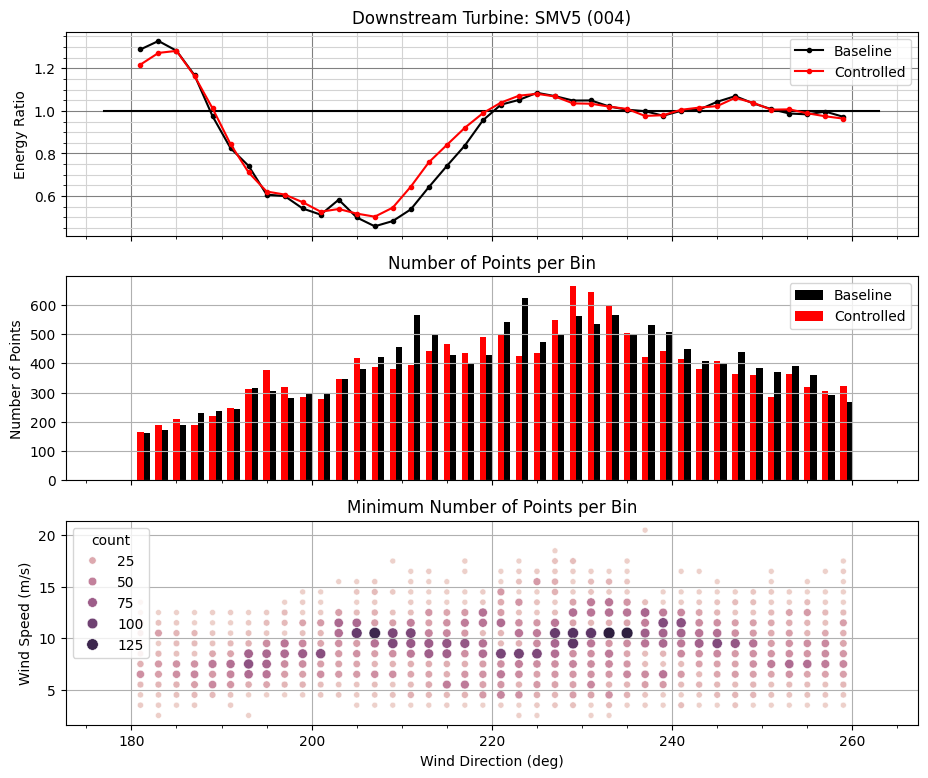

In [12]:
# Check energy ratios on SMV5 (index=4) (downstream turbine)
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
)
ax = er_out.plot_energy_ratios(color_dict=er_colors)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Text(0.5, 1.0, 'Upstream Turbine: SMV6 (005)')

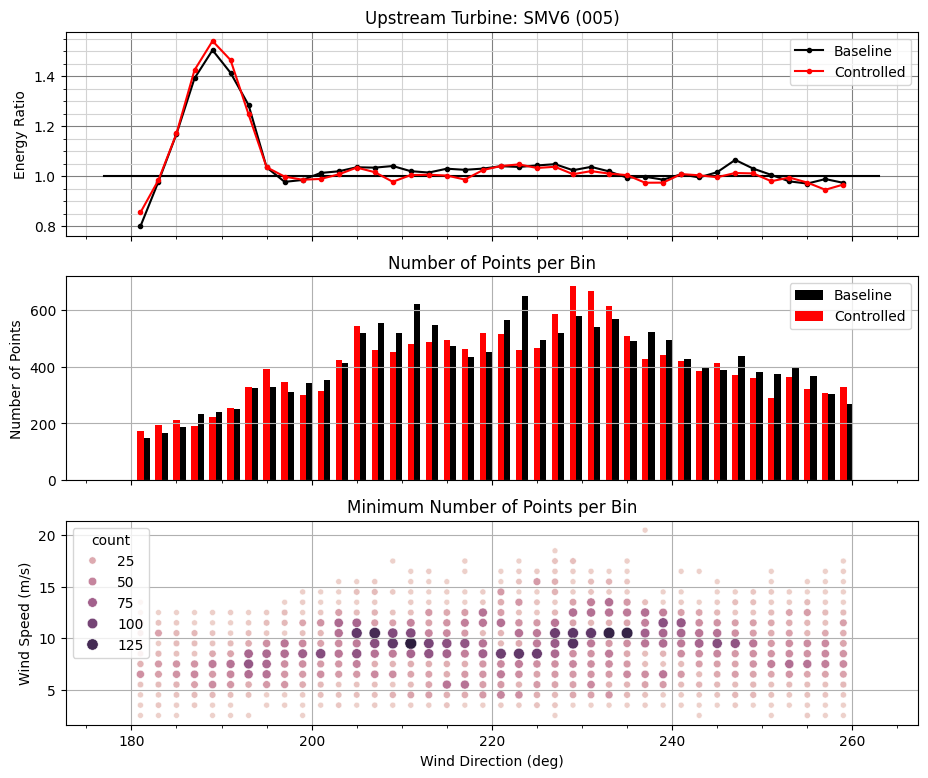

In [13]:
# Check energy ratios on SMV6 (index=5) (upstream turbine)
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[5],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
)
ax = er_out.plot_energy_ratios(color_dict=er_colors)
ax[0].set_title("Upstream Turbine: SMV6 (005)")

Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

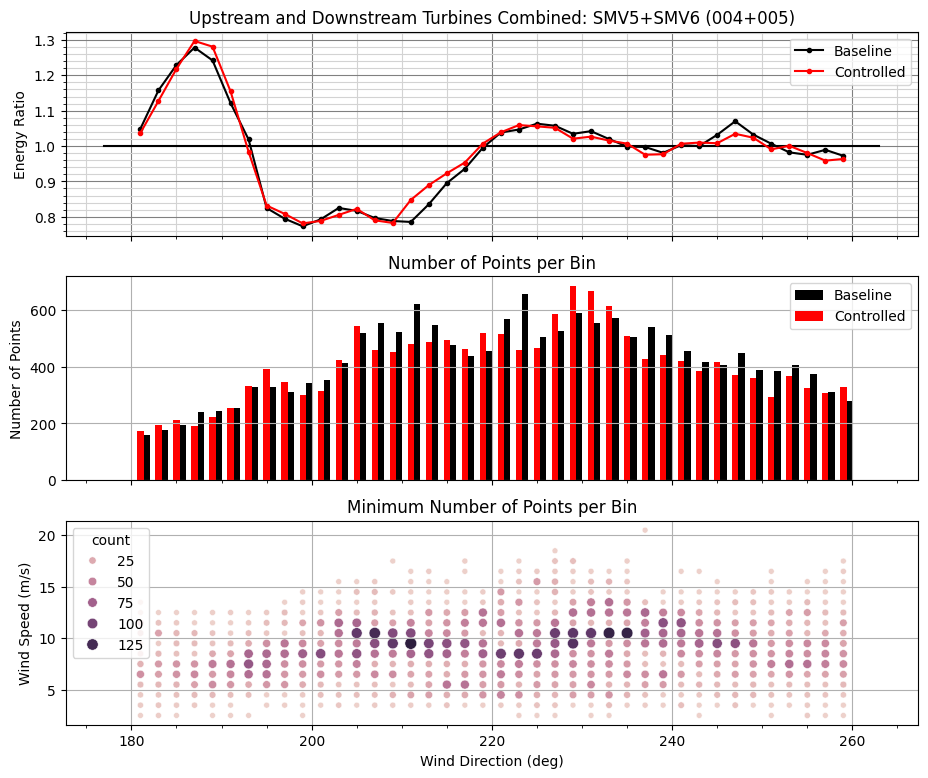

In [14]:
# Check energy ratios on for combination of SMV5 and SMV6
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[5, 4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
)
ax = er_out.plot_energy_ratios(color_dict=er_colors)
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

# Step 4: Use bootstrapping to estimate uncertainty

Now, we'll plot the energy ratio comparisons for the upstream and downstream turbines combined with bootstrapping to quantify uncertainty.

First we'll use normal bootstrapping, in which the timestamps used in the energy ratio calculation are randomly resampled with replacement each bootstrap iteration.

The shaded regions in the plots below indicate the 95% confidence intervals of the mean energy ratio estimates.

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

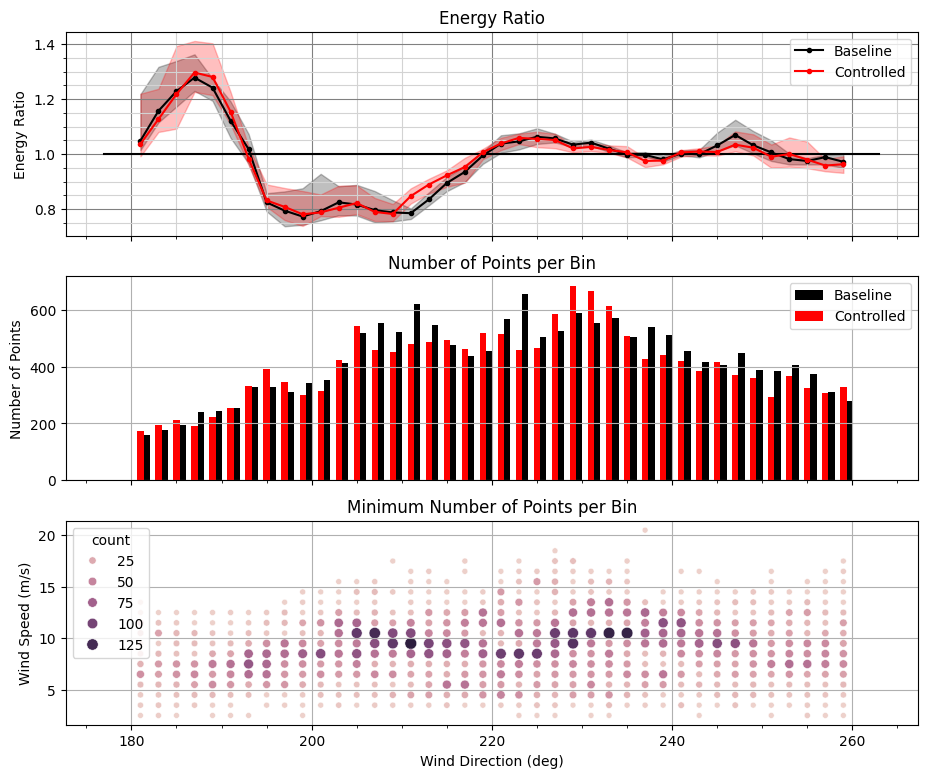

In [15]:
# Check energy ratios on for combination of SMV5 and SMV6
# Using N=40 bootstraps
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[5, 4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    N=40,
)
er_out.plot_energy_ratios(color_dict=er_colors)
# s.plot_energy_ratios(show_barplot_legend=False)

As expected, the uncertainty is higher for wind directions with fewer data samples.

Next we'll use block bootstrapping, in which the data used in the energy ratio calculation are first grouped into blocks of consecutive timestamps and the individual blocks are randomly resampled with replacement each bootstrap iteration. In this example, we'll divide the data into 10 blocks. Block bootstrapping can provide a more realistic estimate of the true uncertainty than normal bootstrapping.

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

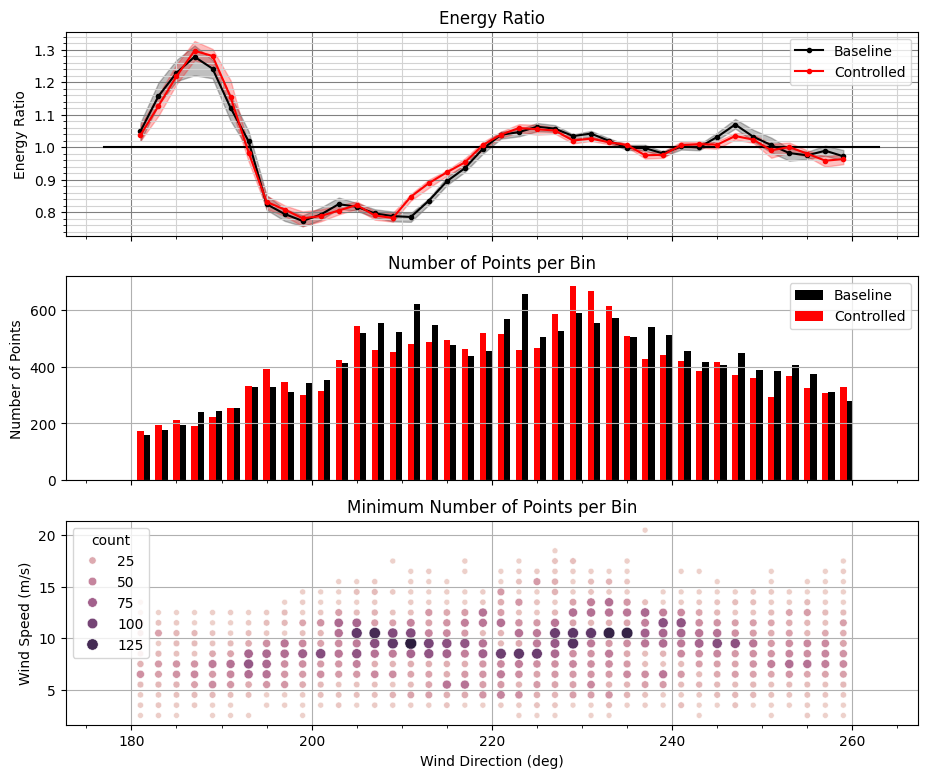

In [16]:
# Check energy ratios on for combination of SMV5 and SMV6
# Using N=40 bootstraps without block bootstrapping
a_in_noblocks = AnalysisInput(
    [df_base, df_con], ["Baseline", "Controlled"], num_blocks=min(len(df_base), len(df_con))
)
er_out = er.compute_energy_ratio(
    a_in_noblocks,
    test_turbines=[5, 4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    N=40,
)
er_out.plot_energy_ratios(color_dict=er_colors)

# Step 6: Plot the energy ratio gain with bootstrapping

Next, we will plot the difference between the energy ratios with and without wake steering. These plots will show how much wake steering increases (or decreases) energy production as a function of wind direction. 

The first plot shows the energy ratio gain for the downstream turbine (SMV5) and the second plot shows the energy gain for the two turbines combined.

Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

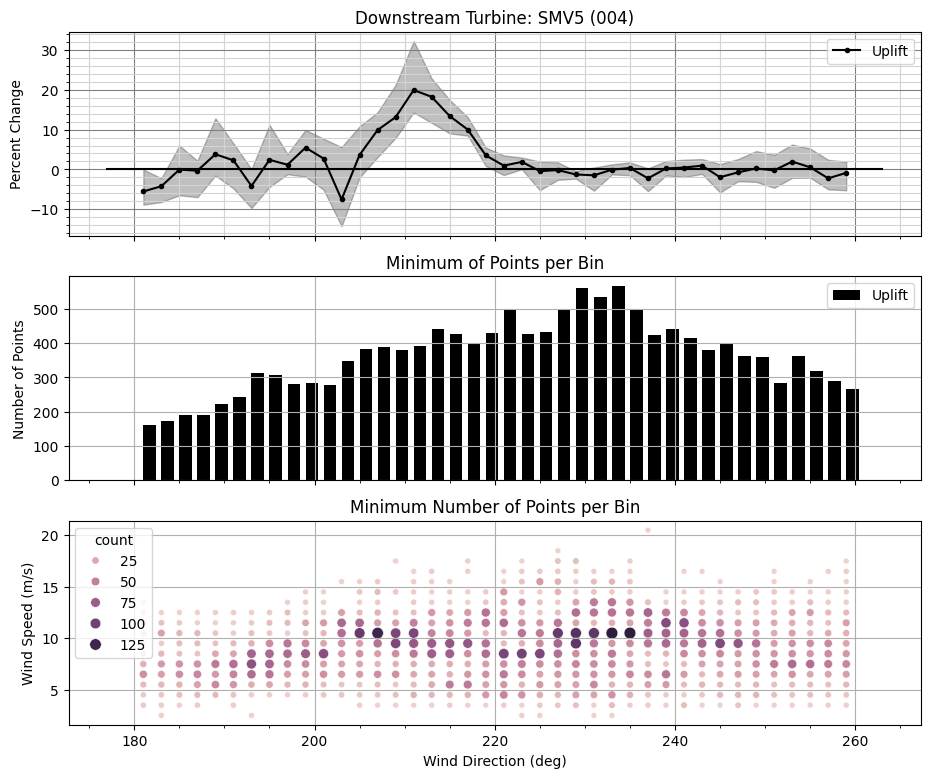

In [17]:
# SMV5 (Downstream)
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["Uplift"],
    N=40,
)
ax = er_out.plot_uplift(color_dict={"Uplift": "black"})
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

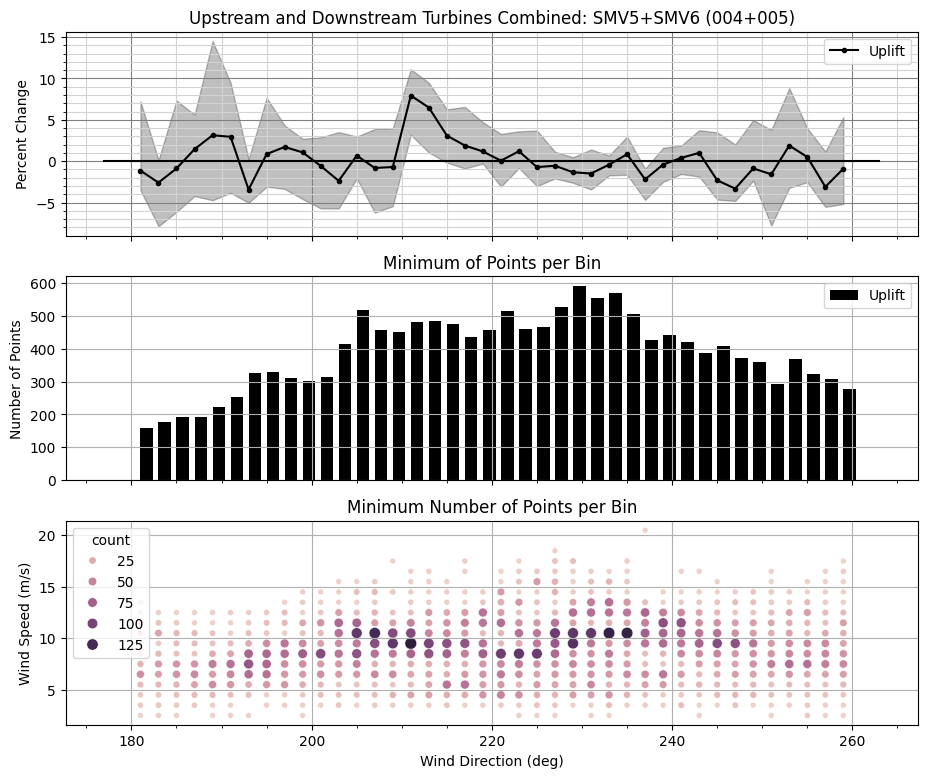

In [18]:
# SMV5 + SMV6 (Combined)
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4, 5],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["Uplift"],
    N=40,
)
ax = er_out.plot_uplift(color_dict={"Uplift": "black"})
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

The above plots indicate that wake steering increases the energy of the downstream turbine significantly for wind directions between 205 and 220 degrees. When including the upstream turbine, the impact on energy is smaller, but wake steering still yields an increase in energy.

# Step 7: Compare with FLORIS

Now we will compare the observed energy ratios and energy ratio gains for baseline and wake steering control based on SCADA data to the equivalent FLORIS predictions.

In [19]:
# Define a small function to build a dataframe of FLORIS predictions with yaw misalignment
# for comparison with SCADA

num_turbines = 7


def build_floris_data_frame(
    fm_in, wind_speeds, wind_directions, yaw_angles_in=None, ref_pow_columns=[0, 1, 2, 6]
):
    fm_ = copy.deepcopy(fm_in)

    yaw_angles = np.zeros([len(wind_directions), num_turbines])
    if yaw_angles_in is not None:
        yaw_angles[:, 5] = yaw_angles_in  # Apply angles to SMV6

    fm_.set(
        wind_speeds=wind_speeds,
        wind_directions=wind_directions,
        turbulence_intensities=0.06 * np.ones_like(wind_speeds),
        yaw_angles=yaw_angles,
    )

    fm_.run()

    turbine_powers = fm_.get_turbine_powers().squeeze() / 1000.0

    df_ = FlascDataFrame(
        turbine_powers, columns=["pow_{:03d}".format(ii) for ii in range(num_turbines)]
    )

    df_ = df_.assign(
        ws=wind_speeds,
        wd=wind_directions,
        pow_ref=df_[["pow_{:03d}".format(ii) for ii in ref_pow_columns]].mean(axis=1),
    )

    return df_

## Comparison assuming no wind direction uncertainty/variability in FLORIS

Compute FLORIS predictions of power production for the time series of reference wind directions and wind speeds in the SCADA data set, using the Gauss-Curl Hybrid wake model. The yaw misalignment of the steered turbine, SMV6 (005), is set to the measured wind vane angle at each timestamp. Yaw misalignments for all other turbines are set to 0.

In [20]:
fm, _ = load_floris("gch", wd_std=0.0)

In [21]:
# Resimulate FLORIS using time-domain sim assuming all
# yaws are 0 except for SMV5, which follows either target exactly or
# what is measured via the vane

# Baseline / Perfect yawing
wind_speeds_baseline = df_base.ws.values
wind_directions_baseline = df_base.wd.values
yaw_angles_baseline_target = None
yaw_angles_baseline_measured = df_base.wind_vane_005.values

wind_speeds_con = df_con.ws.values
wind_directions_con = df_con.wd.values
yaw_angles_con_target = df_con.target_yaw_offset_005.values
yaw_angles_con_measured = df_con.wind_vane_005.values

# Compute FLORIS assuming target offsets and no wd std
df_floris_target_offset_baseline = build_floris_data_frame(
    fm, wind_speeds_baseline, wind_directions_baseline, yaw_angles_baseline_target
)
df_floris_target_offset_con = build_floris_data_frame(
    fm, wind_speeds_con, wind_directions_con, yaw_angles_con_measured
)

Now we'll plot a comparison of the energy ratios based on SCADA data and FLORIS predictions for the downstream turbine SMV5 (004).

Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

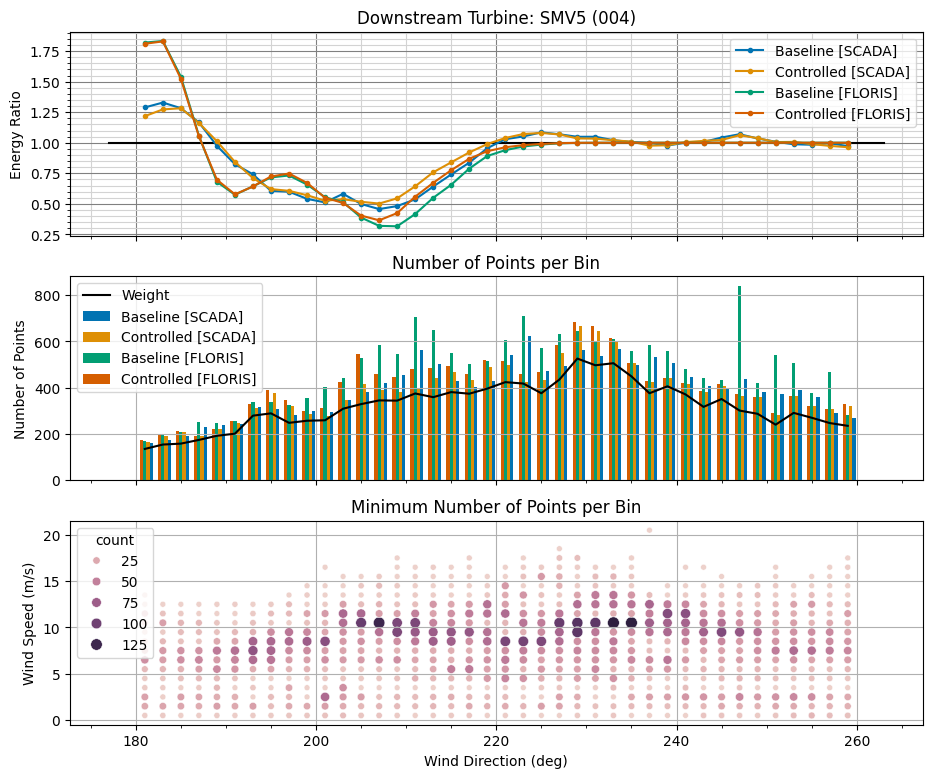

In [22]:
# Construct energy ratio object
a_in = AnalysisInput(
    [df_base, df_con, df_floris_target_offset_baseline, df_floris_target_offset_con],
    ["Baseline [SCADA]", "Controlled [SCADA]", "Baseline [FLORIS]", "Controlled [FLORIS]"],
)

er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
)
ax = er_out.plot_energy_ratios(overlay_frequency=True)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

The FLORIS predictions agree reasonably well with the SCADA-based energy ratios, although FLORIS predicts slightly lower wake losses overall. Note that the SCADA-based energy ratios exceed 1 at the edge of the wake between 220 and 235 degrees, whereas FLORIS predicts energy ratios of 1. The higher SCADA-based energy ratios could indicate a speed up region at the edge of the wake where SMV5 outperforms the reference turbines.  

## Compare the energy ratio gains from SCADA and FLORIS

Lastly, we'll compare the changes in the energy ratios from wake steering based on the SCADA data with the equivalent FLORIS predictions for the downstream turbine adn the two turbines combined.

Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

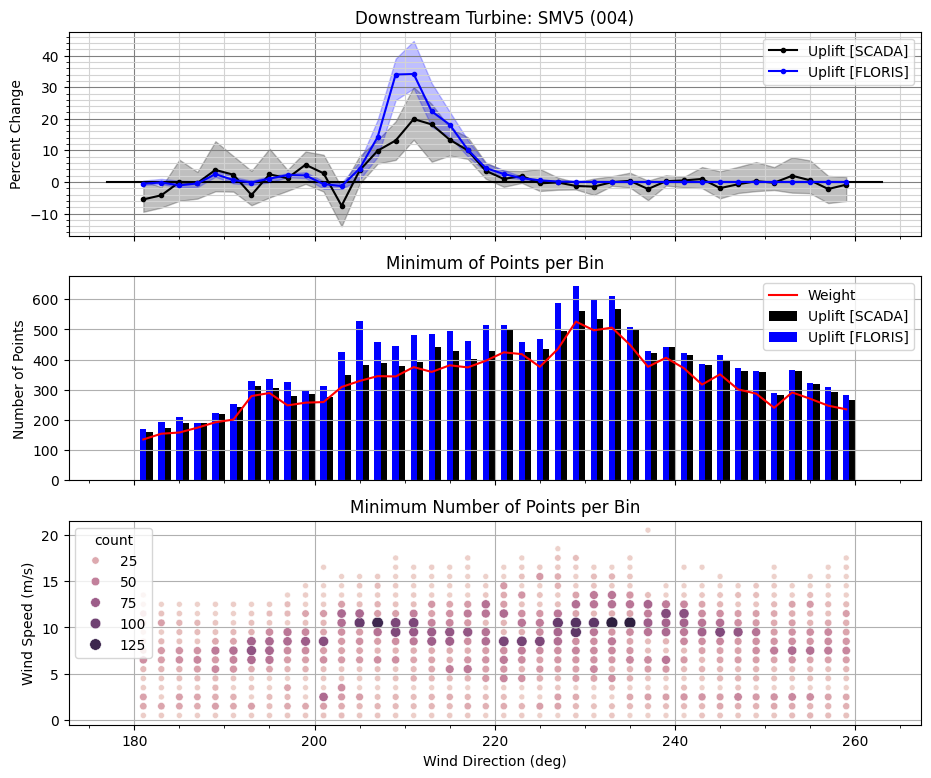

In [23]:
# Downstream only
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    uplift_pairs=[
        ("Baseline [SCADA]", "Controlled [SCADA]"),
        ("Baseline [FLORIS]", "Controlled [FLORIS]"),
    ],
    uplift_names=["Uplift [SCADA]", "Uplift [FLORIS]"],
    N=40,
)
er_uplift_colors = {"Uplift [SCADA]": "black", "Uplift [FLORIS]": "blue", "weight": "red"}

ax = er_out.plot_uplift(color_dict=er_uplift_colors, overlay_frequency=True)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

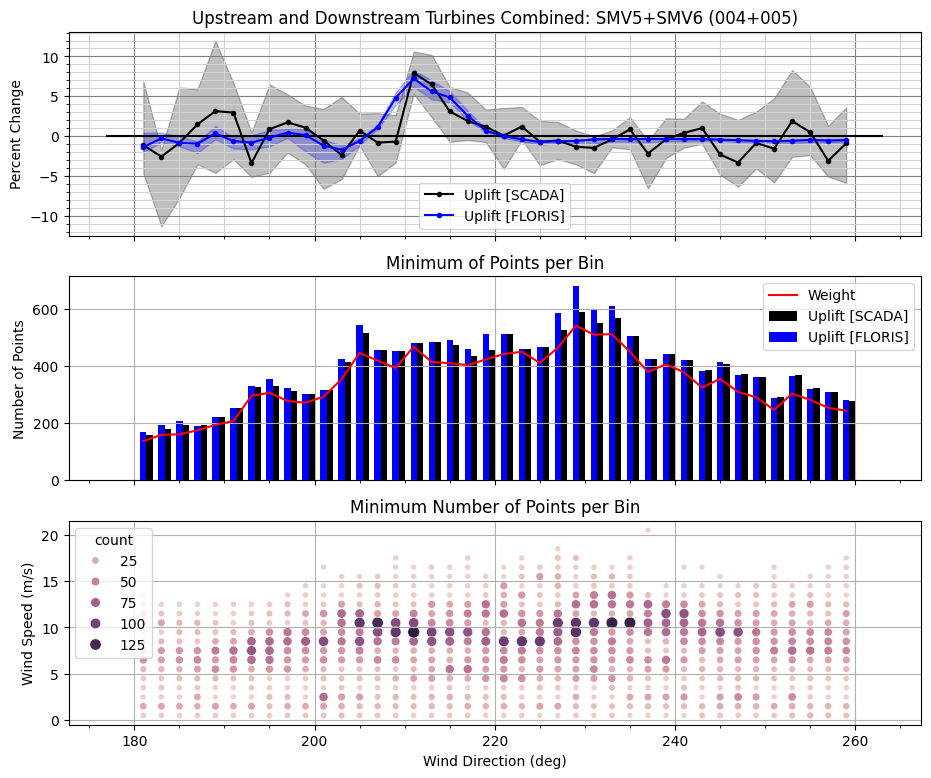

In [24]:
# Combined
er_out = er.compute_energy_ratio(
    a_in,
    test_turbines=[4, 5],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    uplift_pairs=[
        ("Baseline [SCADA]", "Controlled [SCADA]"),
        ("Baseline [FLORIS]", "Controlled [FLORIS]"),
    ],
    uplift_names=["Uplift [SCADA]", "Uplift [FLORIS]"],
    N=40,
)
ax = er_out.plot_uplift(color_dict=er_uplift_colors, overlay_frequency=True)
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

In general, although the SCADA-based energy ratios are much noisier than the FLORIS predictions, the observed energy gains are relatively close to the predicted gains.

## Compare the total uplift amounts above 4m/s

In [25]:
# Downstream only
total_uplift_result = tup.total_uplift_power_ratio(
    a_in,
    test_turbines=[4, 5],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=195.0,  # As in paper
    wd_max=240.0,  # As in paper
    ws_step=1.0,
    ws_min=4.0,
    uplift_pairs=[
        ("Baseline [SCADA]", "Controlled [SCADA]"),
        ("Baseline [FLORIS]", "Controlled [FLORIS]"),
    ],
    uplift_names=["Uplift [SCADA]", "Uplift [FLORIS]"],
    N=100,
    percentiles=(10, 90),  # Use P10 and P90
)


print(
    f"Percent increase in total energy production for combined turbines: "
    f"{total_uplift_result['Uplift [SCADA]']['energy_uplift_ctr_pc']:.3f}% (SCADA)"
)
print(
    f"Percent increase in total energy production for combined turbines: "
    f"{total_uplift_result['Uplift [FLORIS]']['energy_uplift_ctr_pc']:.3f}% (FLORIS)"
)
print(" ")
print("Full contents of dictionary including P10 and P90 values...")
total_uplift_result

Percent increase in total energy production for combined turbines: 0.446% (SCADA)
Percent increase in total energy production for combined turbines: 0.677% (FLORIS)
 
Full contents of dictionary including P10 and P90 values...


{'Uplift [SCADA]': {'energy_uplift_ctr': 40001.0684398531,
  'energy_uplift_lb': -27800.946201485916,
  'energy_uplift_ub': 92608.52673093324,
  'energy_uplift_ctr_pc': 0.44644504168660487,
  'energy_uplift_lb_pc': -0.29492904048746305,
  'energy_uplift_ub_pc': 1.0580637891036924},
 'Uplift [FLORIS]': {'energy_uplift_ctr': 59513.841234969426,
  'energy_uplift_lb': 38235.58175841628,
  'energy_uplift_ub': 76388.4323291305,
  'energy_uplift_ctr_pc': 0.6767282853582994,
  'energy_uplift_lb_pc': 0.42475275231862447,
  'energy_uplift_ub_pc': 0.8992952263645647}}